# Demand Forecasting with a ByteHub Feature Store

Notebook to demonstrate how a [ByteHub feature store](https://www.bytehub.ai/product) makes data access and preparation so simple that a forecasting model can be built in a few lines of code.

Specifically we build a model that forecasts UK electricity demand and show that by simply adding a temperature variable we can improve accuracy by 13%.

## Access

In this demo we use a ByteHub feature store preloaded with weather data feeds (from [the MET Office](https://www.metoffice.gov.uk/)) and UK electricity demand data feeds (from [BMRS](https://www.bmreports.com/bmrs/?q=help/about-us)), this means we can access the right data for our forecasting problem in few lines of code.

The feature store requires login credentials, [get in touch for a free trial](https://www.bytehub.ai/).

Load the feature store

In [ ]:
import bytehub as bh

In [ ]:
fs = bh.FeatureStore(
    endpoint=,
    client_id=
)

Check the data is preloaded. The features we want are `bmrs.feature.indo` and `met-office.data.daily-temperature`.

In [5]:
fs.list_features()

['carbonintensity.data.intensity',
 'carbonintensity.feature.actual',
 'gov-uk.data.covid',
 'bmrs.data.bod',
 'bmrs.feature.lowest-offer',
 'bmrs.feature.highest-bid',
 'bmrs.data.indoitsdo',
 'bmrs.feature.indo',
 'bmrs.feature.itsdo',
 'bmrs.data.fuelhh',
 'bmrs.feature.wind-generation',
 'bmrs.data.dersysdata',
 'bmrs.feature.system-price',
 'bmrs.feature.niv',
 'bmrs.data.rolsysdem',
 'bmrs.feature.rolling-demand',
 'bmrs.feature.demand-30min-history',
 'gov-london.data.cycle',
 'met-office.data.daily-temperature',
 'met-office.data.daily-precip']

Energy demand and temperature data are now at our fingertips! Lets explore the preloaded data. What are the date ranges of the two time-series?

Temperature runs from January 2010

In [6]:
fs.get_first('met-office.data.daily-temperature')

,time,entity,value
0,2010-01-01 00:00:00+00:00,None,-0.5


to September 2020

In [82]:
fs.get_last('met-office.data.daily-temperature')

,time,entity,value
0,2020-09-30 00:00:00+00:00,None,11.6


Demand runs runs from January 2010

In [9]:
fs.get_first('bmrs.feature.indo')

,time,entity,value
0,2013-01-01 00:00:00+00:00,None,30572


to October 2020

In [10]:
fs.get_last('bmrs.feature.indo')

,time,entity,value
0,2020-10-11 22:30:00+00:00,None,23194


On what frequency are the two time-series sampled?

In [ ]:
fs.get_freq('met-office.data.daily-temperature')

In [11]:
fs.get_freq('bmrs.feature.indo')

'30T'

The `get_freq` function returns frequency using the simple convention of [Pandas offset aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). Demand is sampled at a half-hourly frequency and temperature is sampled daily.

## Preparation

Let’s build a model of daily electricity demand between 2013 and 2020. For this we must prepare the data accordingly. In the ByteHub API it is one line of code.

In [84]:
df = fs.get_timeseries(['met-office.data.daily-temperature',
                        'bmrs.feature.indo'],
                       from_date='2013-01-01 00:00:00+00:00',
                       to_date='2020-01-01 00:00:00+00:00',
                       freq='D'
                      )

In [86]:
df.head(5)

,time,entity,met-office.data.daily-temperature,bmrs.feature.indo
0,2013-01-01 00:00:00+00:00,None,5.3,30572.0
1,2013-01-02 00:00:00+00:00,None,7.0,28574.0
2,2013-01-03 00:00:00+00:00,None,8.3,30687.0
3,2013-01-04 00:00:00+00:00,None,8.9,30874.0
4,2013-01-05 00:00:00+00:00,None,9.0,30894.0


Our dataframe of time-series can now simply be fed into a forecasting package like Facebook Prophet.

First let’s build a basic model without temperature

In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly

Rename the target, `y`, and time, `ds`, to conform to the Prophet API.

In [14]:
df.rename(columns={'time': 'ds', 'bmrs.feature.indo': 'y'}, inplace=True)
df['ds'] = df.ds.dt.tz_localize(None)

In [65]:
model = Prophet() 

That's it we're ready to fit the model

In [66]:
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Lets view model fit on the training data

In [67]:
prediction = model.predict(df)

In [68]:
plot_plotly(model, prediction)

Lets do some forecasting. Lets perform a rolling 14 days ahead forecast every 7 days.

In [ ]:
df_cv = cross_validation(model, initial='120 days', period='7 days', horizon='14 days')

INFO:fbprophet:Making 347 forecasts with cutoffs between 2013-05-01 00:00:00 and 2019-12-18 00:00:00


We can now examine the performance.

In [70]:
pm = performance_metrics(df_cv)
pm.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,1.667383e+06,1291.271960,1011.112597,0.040195,0.033253,0.715494
1,3 days,1.957423e+06,1399.079266,1102.154100,0.044367,0.036967,0.665635
2,4 days,2.420779e+06,1555.885189,1194.661422,0.049525,0.040461,0.644291
3,5 days,2.893051e+06,1700.897200,1295.062533,0.055268,0.042913,0.632342
4,6 days,3.525766e+06,1877.702282,1374.936709,0.056429,0.042855,0.634428


Next let’s build a more advanced model that includes temperature

In [71]:
model = Prophet() 

In [72]:
model.add_regressor('met-office.data.daily-temperature')

In [73]:
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Lets visualise model fit

In [74]:
prediction = model.predict(df)

In [75]:
plot_plotly(model, prediction)

Lets perform the same rolling 14 days ahead forecast every 7 days  that we did for the basic model.

In [76]:
df_cv = cross_validation(model, initial='120 days', period='7 days', horizon = '14 days')

INFO:fbprophet:Making 347 forecasts with cutoffs between 2013-05-01 00:00:00 and 2019-12-18 00:00:00


In [77]:
pm_weather = performance_metrics(df_cv)
pm_weather.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,1.397839e+06,1182.302472,924.908836,0.037580,0.030647,0.681779
1,3 days,1.601044e+06,1265.323573,997.643929,0.041074,0.033138,0.671446
2,4 days,1.867647e+06,1366.618654,1061.177360,0.044737,0.035946,0.636840
3,5 days,2.294538e+06,1514.773320,1158.658498,0.050448,0.037754,0.608865
4,6 days,2.737914e+06,1654.664247,1223.168437,0.051055,0.042122,0.598182


Finally compare the performance of the basic model and the model that includes temperature.

In [ ]:
import seaborn as sns

/home/ubuntu/miniconda3/envs/fdemo/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/ubuntu/miniconda3/envs/fdemo/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



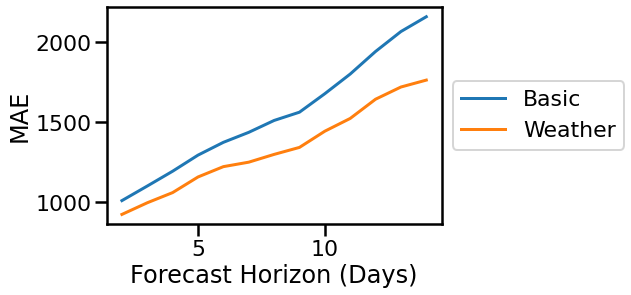

In [81]:
sns.set_context('poster')
ax = sns.lineplot(pm.horizon.map(lambda x: x.days), pm.mae, label='Basic')
sns.lineplot(pm_weather.horizon.map(lambda x: x.days), pm_weather.mae, label='Weather')
ax.set(xlabel='Forecast Horizon (Days)', ylabel='MAE')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.figure.savefig("basic_vs_weather.png", bbox_inches='tight', pad_inches=0)

In [79]:
mae_improvement = 100 * (pm.mae - pm_weather.mae) / pm.mae

In [80]:
mae_improvement.mean()

13.196337692878068

Adding the temperature variable improves performance 13%!